This tutorial will walk you through how to perform basic supervised machine learning (ML) tasks on different types of data that might be relevent for various scientific applications. First we must generate some representative data.

# Generating Data

First, we will generate some nonlinear multi-variate data that will serve as a sufficiently challenging test case for our ML model. The Scikit-Learn library offers some generic routines for generating synthetic data suitable for a range of ML tasks for testing purposes.

In [1]:
# Import the sklearn datasets
import sklearn.datasets as sdt
# Other imports
import numpy as np
import matplotlib.pyplot as plt

For this first example, we will use the Friedman #1 regression function which takes the form: $$f(x)=10sin(\pi x_1 x_2)+ 20(x_3−0.5)^2+10x_4 + 5x_5+ N(0,\sigma) $$

In the following distribution we will create output with 9 features despite the Friedman #1 function only depending upon the first 5 features.

In [2]:
# Create a non-linear distribution using the Friedman #1 function
x, y = sdt.make_friedman1(
        n_samples=100,
        n_features=9,
        noise=0.0,
        random_state=42,
)
y = np.expand_dims(y, axis=1)
print(x.shape, y.shape)

(100, 9) (100, 1)


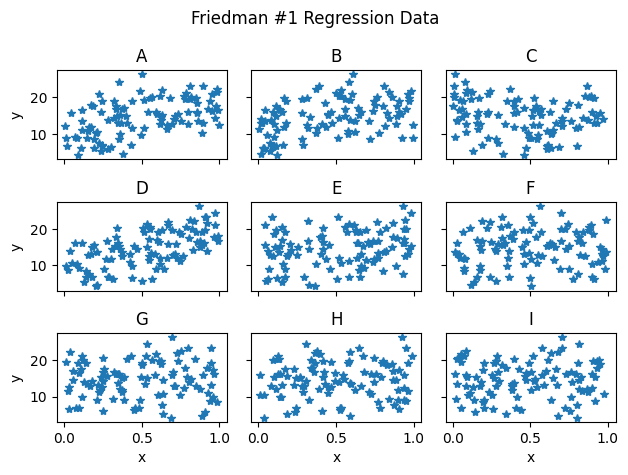

In [3]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Friedman #1 Regression Data')
fig.tight_layout()
plt.show()

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \sigma(x)}{\sqrt{\sigma(x)^2}}$$

We can do this manually, or use a built in function provided as a part of TensorFlow. It is often usefull to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [4]:
# Import tensorflow and Normalization layer
import tensorflow as tf
from tensorflow.keras.layers import Normalization

# Create the normalizing function for x and y
normalizer_x = Normalization()
normalizer_y = Normalization()
# Create the inverse normalizing function
inv_normalizer_x = Normalization(invert=True)
inv_normalizer_y = Normalization(invert=True)

# Adapt the normalization layers to the data we created
normalizer_x.adapt(x)
inv_normalizer_x.adapt(x)
normalizer_y.adapt(y)
inv_normalizer_y.adapt(y)

# Now, create scale the data using the normalizers
x_norm = normalizer_x(x)
y_norm = normalizer_y(y)

2023-10-10 17:21:33.426306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


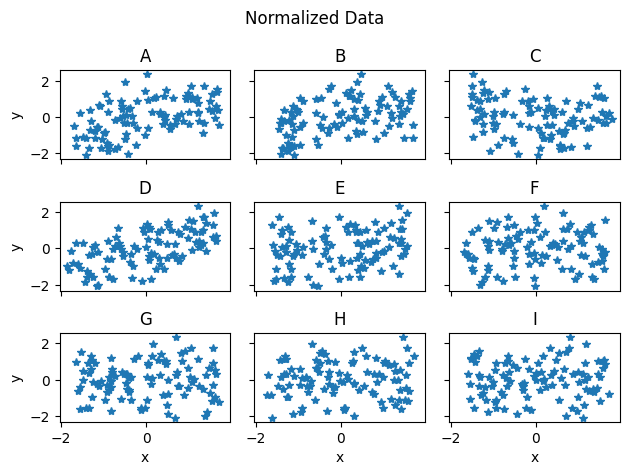

In [5]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x_norm[:,idx], y_norm, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Normalized Data')
fig.tight_layout()
plt.show()

# Creating a ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will be have an input layer, three hidden layer with 32 neurons, and an output layer. The number of hidden layers, neurons per layer, and a variety of other so-called "hyperparameters" will have a noticable impact on model results. These values require extensive tuning depending on the problem at hand.

In [18]:
# Import tensorflow layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

# Form the model using TensorFlow functional form
# Input layer is 9 neurons wide because there are 9 features
inputs = Input(shape=(9,))
# Hidden layer with 32 neurons and relu activation
xtmp = Dense(32, activation='relu')(inputs)
# A second hidden layer with 32 neurons and relu activation
xtmp = Dense(32, activation='relu')(xtmp)
# A third hidden layer with 32 neurons and relu activation
xtmp = Dense(32, activation='relu')(xtmp)
# Output layer with 1 neuron because there is only 1 output feature
xout = Dense(1, activation=None)(xtmp)

# Define the model
model = Model(inputs=inputs, outputs=xout)

model.summary()
# plot_model(model, show_shapes=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2465 (9.63 KB)
Trainable params: 2465 (9.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Now, we compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer)

In [21]:
# Now we can train the model
history = model.fit(
    x_norm,
    y_norm,
    epochs=50,
    validation_split=0.2,
)

Epoch 1/50
3/3 [==============================] - 1s 51ms/step - loss: 1.0242 - val_loss: 0.9217
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9823 - val_loss: 0.9032
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9467 - val_loss: 0.8852
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.9117 - val_loss: 0.8662
Epoch 5/50
3/3 [==============================] - 0s 13ms/step - loss: 0.8779 - val_loss: 0.8417
Epoch 6/50
3/3 [==============================] - 0s 13ms/step - loss: 0.8419 - val_loss: 0.8178
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.8116 - val_loss: 0.7898
Epoch 8/50
3/3 [==============================] - 0s 12ms/step - loss: 0.7717 - val_loss: 0.7562
Epoch 9/50
3/3 [==============================] - 0s 13ms/step - loss: 0.7361 - val_loss: 0.7184
Epoch 10/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6939 - val_loss: 0.6780
Epoch 11/50
3/3 [============

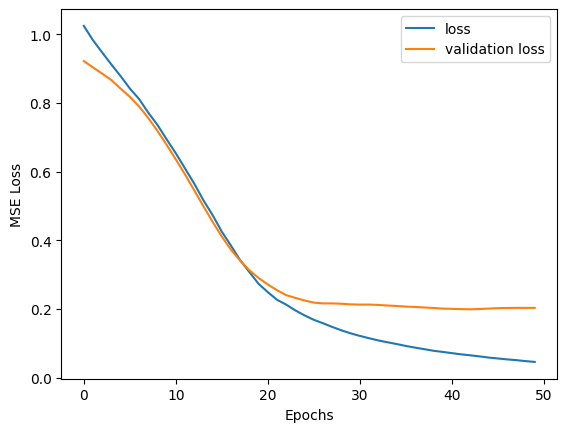

In [22]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [23]:
# Evaluate the model performance
pred_norm = model.predict(x_norm)

# Unscale the results and plot
pred = inv_normalizer_y(pred_norm).numpy()

4/4 [==============================] - 0s 1ms/step


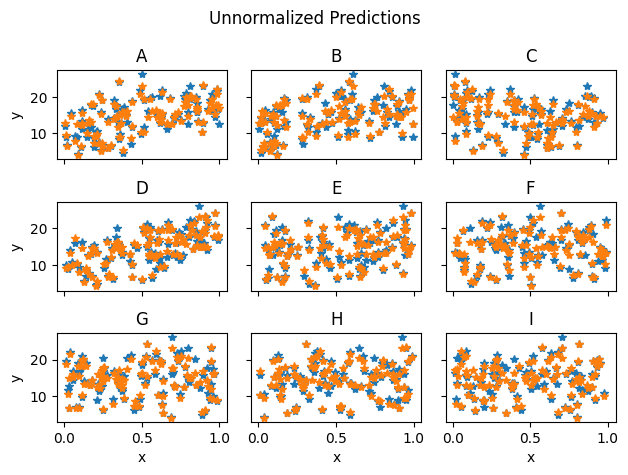

In [24]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions')
fig.tight_layout()
plt.show()

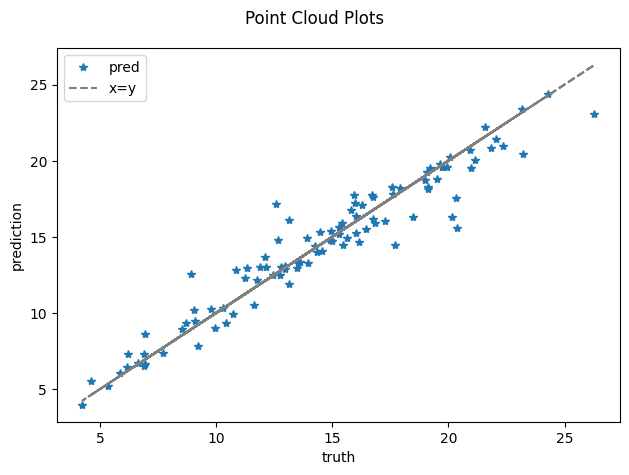

In [26]:
# Visualize the predictions using a cloud plot
fig, ax = plt.subplots(1, 1)
ax.plot(y, pred, marker="*", linestyle="None", label="pred")
ax.plot(y, y, linestyle="dashed", label="x=y", color="grey")
ax.legend()
ax.set_xlabel("truth")
ax.set_ylabel("prediction")
fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

# Using TF-MELT
We have so far shown how to get started with the basics of initializing, training, and testing a model using TensorFlow basics. While this is important to know, there are many different ML architectures that, along with hyperparameters, can have a larger impact on model results and accuracy. Some architectures are better suited to problems than others, and it can oftentimes involve a great deal of trial-and-error to figure out which ML architectures are best for a given dataset and desired outcomes.

To spead up the process of ML architecture discovery and hyperparamter experimentation, the AI/ML team at NREL has developed a toolbox for TensorFlow that allows for the streamlined implementation of a number of commonly used ML architectures. Here we will show how to get started with TF-MELT. We start by pip installing the TF-MELT repository and importing the ArtificialNeuralNetwork (ANN) architecture.

In [27]:
pip install git+https://github.com/NREL/tf-melt.git

  Cloning https://github.com/NREL/tf-melt.git to /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-t2n5c39t
  Running command git clone --filter=blob:none --quiet https://github.com/NREL/tf-melt.git /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-t2n5c39t
  Resolved https://github.com/NREL/tf-melt.git to commit b58fbf6d048f7280761f53a4593e715e4a3f01f4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [28]:
# Import the TF-MELT architecture
from tfmelt.models import ArtificialNeuralNetwork

In [34]:
# Initialize the model
model = ArtificialNeuralNetwork(
    num_feat=9,
    num_outputs=1,
    width=32,
    depth=3,
    act_fun="relu",
    sigmoid=True,
)
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    run_eagerly=False,
)

In [35]:
# Now we can train the model
history = model.fit(
    x_norm,
    y_norm,
    epochs=50,
    validation_split=0.2,
)

Epoch 1/50
3/3 [==============================] - 1s 56ms/step - loss: 1.2689 - val_loss: 1.2368
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 1.2449 - val_loss: 1.2197
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 1.2302 - val_loss: 1.2039
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 1.2145 - val_loss: 1.1861
Epoch 5/50
3/3 [==============================] - 0s 14ms/step - loss: 1.1975 - val_loss: 1.1657
Epoch 6/50
3/3 [==============================] - 0s 12ms/step - loss: 1.1769 - val_loss: 1.1438
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 1.1521 - val_loss: 1.1190
Epoch 8/50
3/3 [==============================] - 0s 12ms/step - loss: 1.1296 - val_loss: 1.0926
Epoch 9/50
3/3 [==============================] - 0s 13ms/step - loss: 1.0982 - val_loss: 1.0656
Epoch 10/50
3/3 [==============================] - 0s 13ms/step - loss: 1.0727 - val_loss: 1.0384
Epoch 11/50
3/3 [============

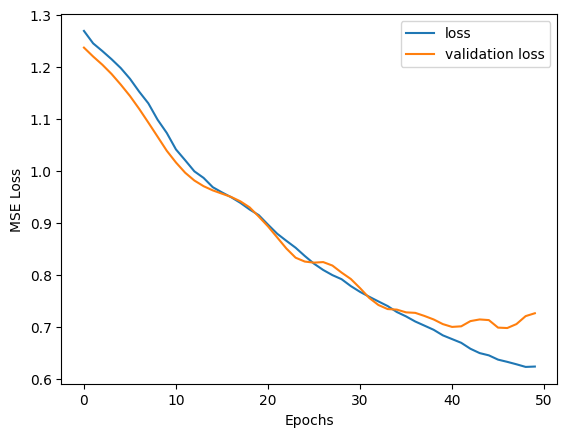

In [36]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [37]:
# Evaluate the model performance
pred_norm = model.predict(x_norm)

# Unscale the results and plot
pred = inv_normalizer_y(pred_norm).numpy()

4/4 [==============================] - 0s 2ms/step


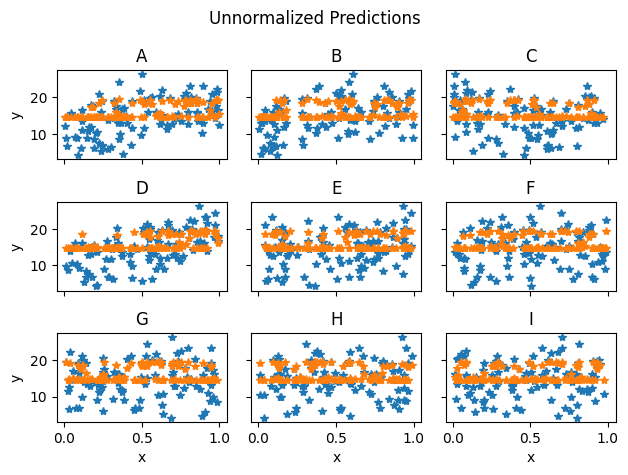

In [38]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions')
fig.tight_layout()
plt.show()

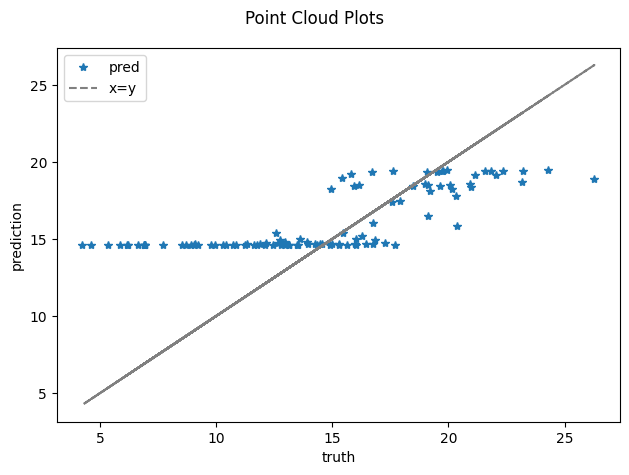

In [39]:
# Visualize the predictions using a cloud plot
fig, ax = plt.subplots(1, 1)
ax.plot(y, pred, marker="*", linestyle="None", label="pred")
ax.plot(y, y, linestyle="dashed", label="x=y", color="grey")
ax.legend()
ax.set_xlabel("truth")
ax.set_ylabel("prediction")
fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()